### 1.Preprocessing data 

In [1]:
def parse_line(line):
    
    parts = line.strip().split()
    label = parts[0]
    
    # Handle potential format issues
    try:
        coordinates = [float(coord) for coord in ' '.join(parts[1:]).replace(',', ' ').split()]
    except ValueError as e:
        print(f"Error parsing line: {line}\n{e}")
        coordinates = []
        
    return label, coordinates


def read_txt_file(file_path, parse_fn):
    labels = []
    all_coordinates = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, coordinates = parse_fn(line)
            if coordinates:  # Check if coordinates list is not empty
                labels.append(label)
                all_coordinates.append(coordinates)
                # print("label:", label, "Coor_:", coordinates)
    return labels, all_coordinates

def split_txt(coordinates, sub_str):
    return [coordinates[i:i + sub_str] for i in range(0, len(coordinates), sub_str)]


# File path
file_path = '/home/ubuntu-vilalab/Desktop/Ham Heng /Char true or flase/Experiment 3 (Kh char)/kor-or file txt /train(80%).txt'
# Read
labels, coordinates_list = read_txt_file(file_path, parse_line)

print("Length of labels:", len(labels))
print("Length of coordinates_list:", len(coordinates_list))
unique_words = set(labels)
num_unique_words = len(unique_words)
print("Number of unique words:", num_unique_words)

Length of labels: 14555
Length of coordinates_list: 14555
Number of unique words: 33


### Dictionary 

In [2]:
khmer_dictionary = {
    # khmer_consonants
    'ក': 0, 'ខ': 1, 'គ': 2, 'ឃ': 3, 'ង': 4,
    'ច': 5, 'ឆ': 6, 'ជ': 7, 'ឈ': 8, 'ញ': 9,
    'ដ': 10, 'ឋ': 11, 'ឌ': 12, 'ឍ': 13, 'ណ': 14,
    'ត': 15, 'ថ': 16, 'ទ': 17, 'ធ': 18, 'ន': 19,
    'ប': 20, 'ផ': 21, 'ព': 22, 'ភ': 23, 'ម': 24,
    'យ': 25, 'រ': 26, 'ល': 27, 'វ': 28, 'ស': 29,
    'ហ': 30, 'ឡ': 31, 'អ': 32,

}

khmer_dict_reverse = {
    # khmer_consonants
    0: 'ក', 1: 'ខ', 2: 'គ', 3: 'ឃ', 4: 'ង',
    5: 'ច', 6: 'ឆ', 7: 'ជ', 8: 'ឈ', 9: 'ញ',
    10: 'ដ', 11: 'ឋ', 12: 'ឌ', 13: 'ឍ', 14: 'ណ',
    15: 'ត', 16: 'ថ', 17: 'ទ', 18: 'ធ', 19: 'ន',
    20: 'ប', 21: 'ផ', 22: 'ព', 23: 'ភ', 24: 'ម',
    25: 'យ', 26: 'រ', 27: 'ល', 28: 'វ', 29: 'ស',
    30: 'ហ', 31: 'ឡ', 32: 'អ',
    
}


#Khmer to int
def khmer_to_num_char(khmer_word, khmer_dict):
    num_list = []
    for khmer_char in khmer_word:
        num_value = khmer_dict.get(khmer_char)
        if num_value is not None:
            num_list.append(num_value)
        else:
            print(f"Warning: '{khmer_char}' not found in the dictionary.")
    return num_list

#int to khmer 
def num_to_khmer_char(num_list, khmer_dict_reverse):
    khmer_word = ""
    for num_value in num_list:
        khmer_char = khmer_dict_reverse.get(num_value)
        if khmer_char is not None:
            khmer_word += khmer_char
            
        else:
            print(f"Warning: Numeric value {num_value} not found in the dictionary.")
    return khmer_word



#-----------​Test-----------
khmer_word = 'ត'
print("Khmer Word Numbers: ", khmer_to_num_char(khmer_word, khmer_dictionary))
a=[15]
print('word : ', num_to_khmer_char(a,khmer_dict_reverse))


print(len(khmer_dictionary))
print(len(khmer_dict_reverse))


Khmer Word Numbers:  [15]
word :  ត
33
33


CustomDataset

---

In [3]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, file_path, sub_str, label_to_index, index_to_label, khmer_dict, parse_fn=parse_line, split_fn=split_txt):
        self.labels, self.coordinates_list = read_txt_file(file_path, parse_fn)
        self.sub_str = sub_str
        self.split_fn = split_fn
        self.label_to_index = label_to_index
        self.index_to_label = index_to_label
        self.khmer_dict = khmer_dict
        self.khmer_to_num = khmer_to_num_char

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        coordinates = self.coordinates_list[idx]
        
        # Split coordinates into sub-strokes
        strokes = self.split_fn(coordinates, self.sub_str)

        # Convert label to index
        label_index = self.khmer_to_num(label,self.label_to_index)

        # Return sub-strokes and label index
        return strokes, label_index

# Create an instance of CustomDataset
dataset_char = CustomDataset(file_path, sub_str=54, label_to_index=khmer_dictionary, index_to_label=khmer_dict_reverse, khmer_dict=khmer_dictionary)


In [4]:
max_output_length = 0

for input_data,output_data in dataset_char:
    output_length = len(output_data)
    #int no len 
    max_output_length = max(max_output_length, output_length)

print("Maximum output sequence length:", max_output_length)

Maximum output sequence length: 1


In [5]:
import re

# Regular expression pattern for Khmer Unicode range
khmer_pattern = re.compile(r'[\u1780-\u17FF\s]+')

# For label convert into int
for label in dataset_char.labels:
    if not khmer_pattern.fullmatch(label):
        print(f"Label '{label}' contains a non-Khmer word.")

In [6]:

for label in labels:
    label_index = dataset_char.khmer_to_num(label,dataset_char.label_to_index)
    if label_index is None:
        print(f"Conversion failed for label: {label}")
    else:
        print(f"{label}={label_index}")
        

ឡ=[31]
ឈ=[8]
ង=[4]
ស=[29]
ឍ=[13]
ជ=[7]
ឆ=[6]
ព=[22]
ធ=[18]
ខ=[1]
ឋ=[11]
ដ=[10]
ដ=[10]
ត=[15]
ថ=[16]
ឃ=[3]
ច=[5]
ដ=[10]
ទ=[17]
ឌ=[12]
ឍ=[13]
រ=[26]
ន=[19]
ថ=[16]
ឌ=[12]
ហ=[30]
ផ=[21]
ខ=[1]
អ=[32]
ឋ=[11]
ព=[22]
យ=[25]
ស=[29]
ង=[4]
ឈ=[8]
ថ=[16]
ថ=[16]
ល=[27]
យ=[25]
ឡ=[31]
វ=[28]
ហ=[30]
ប=[20]
ក=[0]
ស=[29]
ញ=[9]
យ=[25]
ត=[15]
ព=[22]
ថ=[16]
ទ=[17]
អ=[32]
ឡ=[31]
ឍ=[13]
ភ=[23]
ក=[0]
ណ=[14]
ឈ=[8]
ល=[27]
ហ=[30]
ហ=[30]
ព=[22]
ខ=[1]
ព=[22]
ន=[19]
យ=[25]
ក=[0]
ក=[0]
ណ=[14]
ឡ=[31]
រ=[26]
ឋ=[11]
ថ=[16]
ភ=[23]
ធ=[18]
ភ=[23]
ម=[24]
រ=[26]
ស=[29]
ឆ=[6]
ឈ=[8]
ហ=[30]
ល=[27]
រ=[26]
ឃ=[3]
ខ=[1]
ថ=[16]
ឃ=[3]
ត=[15]
ច=[5]
ឡ=[31]
ព=[22]
ឋ=[11]
ប=[20]
យ=[25]
ភ=[23]
ន=[19]
ប=[20]
ខ=[1]
រ=[26]
ខ=[1]
ឍ=[13]
អ=[32]
ឍ=[13]
ធ=[18]
ធ=[18]
ជ=[7]
ឡ=[31]
យ=[25]
ក=[0]
ឋ=[11]
ឆ=[6]
អ=[32]
ថ=[16]
ប=[20]
ត=[15]
ឌ=[12]
ក=[0]
រ=[26]
ឆ=[6]
ព=[22]
ដ=[10]
ផ=[21]
ដ=[10]
ល=[27]
ទ=[17]
វ=[28]
ណ=[14]
ត=[15]
ច=[5]
គ=[2]
ក=[0]
វ=[28]
ឋ=[11]
អ=[32]
ណ=[14]
ហ=[30]
ផ=[21]
ណ=[14]
ឌ=[12]
ម=[24]
ខ=[1]
ខ=[1]
ម=[24]
ធ=[18]
ម=[24]
ឌ=[12]
ឆ=[6]


In [1]:
import torch
import torch.nn.functional as F


def my_collate_fn(batch):
    # Separate sub-strokes and labels
    x, y = zip(*batch)


    max_sub_stroke_length = [max(len(sub_stroke) for sub_stroke in sample_x) for sample_x in x]
    max_length_within_batch = max(max_sub_stroke_length)
    padded_x = []
    for sample_x, max_length in zip(x, max_sub_stroke_length):
        padded_sub_strokes = []
        for sub_stroke in sample_x:
            sub_stroke = [coord for coord in sub_stroke if isinstance(coord, (int, float))]
            pad_length = max_length_within_batch - len(sub_stroke)
            padded_sub_stroke = torch.tensor(sub_stroke + [0] * pad_length)
            padded_sub_strokes.append(padded_sub_stroke)
        padded_sub_strokes = torch.stack(padded_sub_strokes)
        padded_x.append(F.pad(padded_sub_strokes, (0, 0, 0, max_length_within_batch - padded_sub_strokes.size(0))))


    # Stack the padded sub-strokes
    padded_x = torch.stack(padded_x)
    
    # Pad label indices batch to the same length
    padded_y = []
    max_len_label = 1
    for label in y:
        if isinstance(label, int):
            label = [label]
        padded_label = label[:max_len_label] + [0] * (max_len_label - len(label))
        padded_y.append(padded_label)

    # Stack the padded labels
    padded_y_tensor = torch.tensor(padded_y, dtype=torch.long)

    # Additional padding for 2D tensors (x)
    pad_size = 60
    needed_pad = pad_size - padded_x.size(1)
    padded_2dim= F.pad(padded_x, (0, 0, 0, needed_pad, 0, 0))

    return  padded_2dim , padded_y_tensor

**DATALOADER**

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_char, batch_size=32, shuffle=True, collate_fn=my_collate_fn)
for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i}: Input_dim: {x.size()}, Output_dim: {y.size()}")

Batch 0: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 1: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 2: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 3: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 4: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 5: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 6: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 7: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 8: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 9: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 10: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 11: Input_dim: torch.Size([32, 60, 54]), Output_dim: torch.Size([32, 1])
Batch 12: Input_dim: torch.Size([32, 60, 54]), Output_dim: tor

In [9]:
x, y = next(iter(train_loader))

print("Shape of input data:", x.shape)
print("Shape of output data:", y.shape)

Shape of input data: torch.Size([32, 60, 54])
Shape of output data: torch.Size([32, 1])


In [10]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Number of Sequences: {len(y)}")

    for sequence_idx in range(x.size(0)):
        print(f"Label for Sequence {sequence_idx + 1}: {y[sequence_idx].tolist()}")
        print(f"Sub-Strokes for Sequence {sequence_idx + 1}:")
        for sub_stroke_idx in range(x.size(1)):
            print(x[sequence_idx, sub_stroke_idx].tolist())

    break  # Only print the first batch

Batch 1:
Number of Sequences: 32
Label for Sequence 1: [12]
Sub-Strokes for Sequence 1:
[0.248649001121521, 0.21457499265670776, 0.259458988904953, 0.21457499265670776, 0.30270299315452576, 0.23886600136756897, 0.3459460139274597, 0.2712549865245819, 0.3621619939804077, 0.3117409944534302, 0.3567569851875305, 0.34008100628852844, 0.30270299315452576, 0.37651801109313965, 0.22702699899673462, 0.3846150040626526, 0.15675699710845947, 0.37651801109313965, 0.09189199656248093, 0.3360320031642914, 0.021622000262141228, 0.25506100058555603, 0.0, 0.1740889996290207, 0.010811000131070614, 0.11740899831056595, 0.07027000188827515, 0.08097200095653534, 0.15135100483894348, 0.07287400215864182, 0.259458988904953, 0.08501999825239182, 0.3567569851875305, 0.10931199789047241, 0.43783798813819885, 0.13360300660133362, 0.4810810089111328, 0.13765199482440948, 0.5027030110359192, 0.12145700305700302, 0.5027030110359192, 0.09311699867248535, 0.51351398229599, 0.048583000898361206, 0.5405409932136536, 0

Khmer representation of [0]: 'ក'


/home/ubuntu-vilalab/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


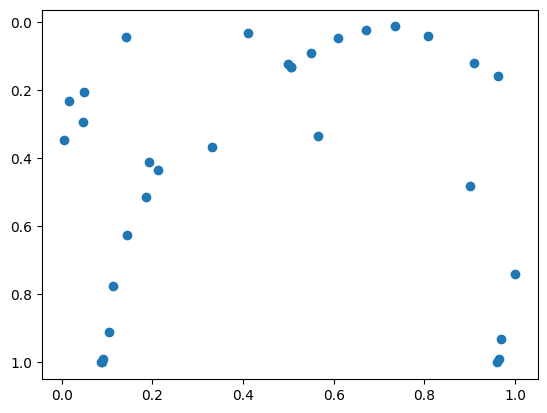

In [11]:
import matplotlib.pyplot as plt
import numpy as np

num_value = [0]
khmer_word = num_to_khmer_char(num_value,khmer_dict_reverse)
if khmer_word is not None:
    print(f"Khmer representation of {num_value}: '{khmer_word}'")



#____________________COORDINATES______________________

a1=[0.08799999952316284, 1.0, 0.0860000029206276, 1.0, 0.09200000017881393, 0.9903470277786255, 0.10400000214576721, 0.9092659950256348, 0.11400000005960464, 0.77606201171875, 0.14399999380111694, 0.625482976436615, 0.1860000044107437, 0.5154439806938171, 0.3319999873638153, 0.36679500341415405, 0.5659999847412109, 0.33397701382637024, 0.8999999761581421, 0.48262500762939453, 1.0, 0.7393820285797119, 0.9679999947547913, 0.9305019974708557, 0.9639999866485596, 0.9884170293807983, 0.9599999785423279, 1.0, 0.21199999749660492, 0.43629300594329834, 0.19200000166893005, 0.4111970067024231, 0.04800000041723251, 0.2953670024871826, 0.01600000075995922, 0.2335910052061081, 0.0, 0.14285700023174286, 0.04399999976158142, 0.04826299846172333, 0.20600000023841858, 0.005791999865323305, 0.3479999899864197, 0.0, 0.4099999964237213, 0.0328189991414547, 0.5, 0.12355200201272964, 0.5059999823570251, 0.13320499658584595, 0.5059999823570251, 0.13320499658584595, 0.550000011920929, 0.09073399752378464]
a2=[0.6100000143051147, 0.04633200168609619, 0.671999990940094, 0.023166000843048096, 0.734000027179718, 0.013513999991118908, 0.8080000281333923, 0.04054100066423416, 0.9100000262260437, 0.11969099938869476, 0.9620000123977661, 0.1583009958267212, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#________________PLOT_______________

sub_stroke = a1+a2
# clean 0
sub_stroke = [value for value in sub_stroke if value not in [0.0]]
# Reshape the flat list into pairs of (x, y)
x_coords = sub_stroke[0::2]   # even index
y_coords = sub_stroke[1::2]  # odd index

fig, ax = plt.subplots()
ax.scatter(x_coords, y_coords)
# Invert the y-axis
ax.invert_yaxis()

plt.show()

In [12]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size // 2, num_layers=num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)

    def forward(self, x):
        # x shape: (batch_size, seq_len, n_features)
        outputs, (h, c) = self.lstm(x)
        # Concatenate the hidden states for both directions
        h = torch.cat((h[-2], h[-1]), dim=1)
        return outputs, h

class Decoder(nn.Module):
    def __init__(self, hidden_size, max_label_length, num_classes, num_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.max_label_length = max_label_length
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.out_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, h, encoder_output):
        # Prepare initial states
        h = h.unsqueeze(0).repeat(self.num_layers, 1, 1)  # Repeat for each layer
        c = torch.zeros_like(h)  # Initial cell states
        # Prepare decoder inputs, initial hidden state only, inputs will be generated
        inputs = torch.zeros(encoder_output.size(0), self.max_label_length, self.hidden_size).to(h.device)
        outputs, (hn, cn) = self.lstm(inputs, (h, c))
        outputs = self.out_layer(outputs)
        outputs = outputs.transpose(1, 2)

        return outputs

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoder_output, last_hidden_state = self.encoder(x)
        decoder_output = self.decoder(last_hidden_state, encoder_output)
        return decoder_output



# Define the dimensions
hidden_size = 1024
batch_size = 32
num_substrokes = 60
substroke_length = 54
num_classes =33
max_label_length = 1
dropout= 0.2
num_layer= 3


encoder = Encoder(input_size=substroke_length, hidden_size=hidden_size, num_layers=num_layer, dropout=dropout)
decoder = Decoder(hidden_size=hidden_size, max_label_length=max_label_length, num_classes=num_classes, num_layers=num_layer, dropout=dropout)
model = EncoderDecoder(encoder, decoder)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model=model.to(device)

print("Model architecture:")
print(model, '\n')

# Test the updated model
input_tensor = torch.randn(batch_size, num_substrokes, substroke_length).to(device)
output = model(input_tensor)
print("Output shape:", output.shape)  

# Expected Shape: (batch_size,, num_classes, max_label_length)




Device: cuda
Model architecture:
EncoderDecoder(
  (encoder): Encoder(
    (lstm): LSTM(54, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1024, 1024, num_layers=3, batch_first=True, dropout=0.2)
    (out_layer): Linear(in_features=1024, out_features=33, bias=True)
  )
) 

Output shape: torch.Size([32, 33, 1])


### Trainig 

In [13]:
file_path = '/home/ubuntu-vilalab/Desktop/Ham Heng /Char true or flase/Experiment 3 (Kh char)/kor-or file txt /train(80%).txt'
dataset_train = CustomDataset(file_path, sub_str=54, label_to_index=khmer_dictionary, index_to_label=khmer_dict_reverse, khmer_dict=khmer_dictionary)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn= my_collate_fn)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 100
losses = []

coss_function = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for i, (b_x, b_y) in enumerate(train_loader):

        b_x=b_x.to(device)
        b_y=b_y.to(device)


        d_output = model(b_x)  
        
        # print(d_output.shape)
        # print(b_y.shape)  
        

        loss = coss_function(d_output, b_y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        if i % 100 == 0:
            print('Epoch: %03d, i: %03d, Loss: %.10f' % (epoch, i, loss.item()))

        losses.append(loss.item())

# Save the model 
torch.save(model.state_dict(), f"model_epoch_{epoch+1}_char_33_air-writing_dataset.pth")



Epoch: 000, i: 000, Loss: 3.4953434467
Epoch: 000, i: 100, Loss: 2.6597685814
Epoch: 000, i: 200, Loss: 1.6302585602
Epoch: 000, i: 300, Loss: 1.1558426619
Epoch: 000, i: 400, Loss: 0.8513783216
Epoch: 001, i: 000, Loss: 0.9444522262
Epoch: 001, i: 100, Loss: 0.9573675394
Epoch: 001, i: 200, Loss: 0.9337381721
Epoch: 001, i: 300, Loss: 0.5858510137
Epoch: 001, i: 400, Loss: 0.3802498579
Epoch: 002, i: 000, Loss: 0.5389688611
Epoch: 002, i: 100, Loss: 0.5378884673
Epoch: 002, i: 200, Loss: 0.3338578641
Epoch: 002, i: 300, Loss: 0.3257508278
Epoch: 002, i: 400, Loss: 0.2178319246
Epoch: 003, i: 000, Loss: 0.5123715997
Epoch: 003, i: 100, Loss: 0.3845628202
Epoch: 003, i: 200, Loss: 0.4905302227
Epoch: 003, i: 300, Loss: 0.5810928345
Epoch: 003, i: 400, Loss: 0.2173614651
Epoch: 004, i: 000, Loss: 0.2541039884
Epoch: 004, i: 100, Loss: 0.0592062250
Epoch: 004, i: 200, Loss: 0.3775958717
Epoch: 004, i: 300, Loss: 0.3680398166
Epoch: 004, i: 400, Loss: 0.2606571019
Epoch: 005, i: 000, Loss:

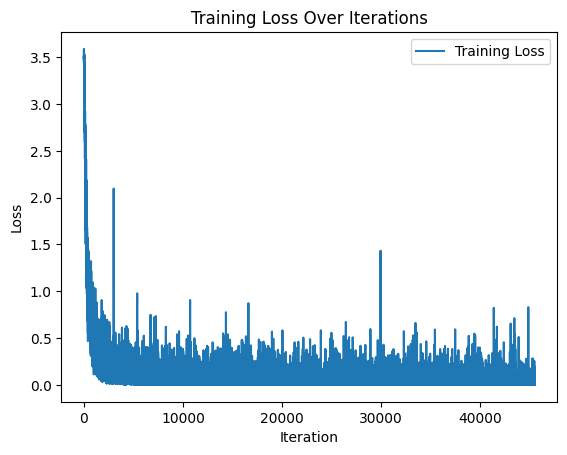

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.show()

### Evaluate 

Test

In [16]:
file_path_test = '/home/ubuntu-vilalab/Desktop/Ham Heng /Char true or flase/Experiment 3 (Kh char)/kor-or file txt /test(10%).txt'
data_test = CustomDataset(file_path_test, sub_str=54, label_to_index=khmer_dictionary, index_to_label=khmer_dict_reverse, khmer_dict=khmer_dictionary)
test_loader = DataLoader(data_test, batch_size=32, shuffle=True, collate_fn=my_collate_fn)

Train

In [17]:
file_path_Train = '/home/ubuntu-vilalab/Desktop/Ham Heng /Char true or flase/Experiment 3 (Kh char)/kor-or file txt /train(80%).txt'
data_train = CustomDataset(file_path_Train, sub_str=54, label_to_index=khmer_dictionary, index_to_label=khmer_dict_reverse, khmer_dict=khmer_dictionary)
train_loader = DataLoader(data_train, batch_size=32, shuffle=True, collate_fn=my_collate_fn)

Valid

In [18]:
file_path_valid= '/home/ubuntu-vilalab/Desktop/Ham Heng /Char true or flase/Experiment 3 (Kh char)/kor-or file txt /valid(10%).txt'
data_valid = CustomDataset(file_path_valid, sub_str=54, label_to_index=khmer_dictionary, index_to_label=khmer_dict_reverse, khmer_dict=khmer_dictionary)
valid_loader = DataLoader(data_valid, batch_size=32, shuffle=True, collate_fn=my_collate_fn)

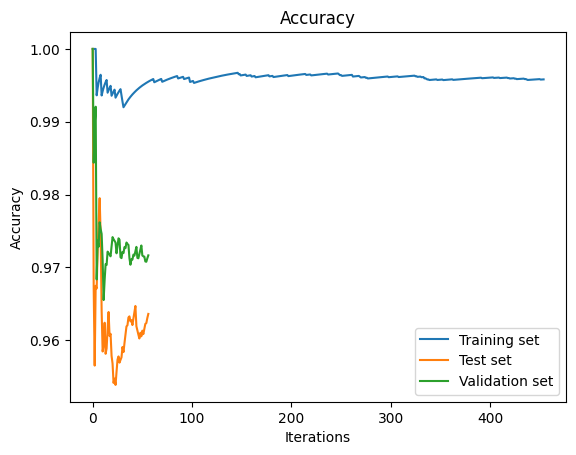

Final Accuracy on Training set: 0.9958
Final Accuracy on Test set: 0.9636
Final Accuracy on Validation set: 0.9717


In [19]:
import matplotlib.pyplot as plt
import torch

# Function to compute accuracies
def compute_accuracies(loader, model, device):
    correct = 0
    total_samples = 0
    accuracies = []

    with torch.no_grad():
        for b_x, b_y in loader:
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            output = model(b_x)
            predict = torch.argmax(output, dim=1)
            mask = (b_y != 0)
            correct += ((predict[mask] == b_y[mask]).sum().item())
            total_samples += mask.sum().item()  # Count only non-padded samples
            accuracy = correct / total_samples
            accuracies.append(accuracy)

    return accuracies

# Assuming model, device, train_loader, test_loader, and valid_loader are defined
train_accuracies = compute_accuracies(train_loader, model, device)
test_accuracies = compute_accuracies(test_loader, model, device)
valid_accuracies = compute_accuracies(valid_loader, model, device)

# Plot the accuracies
plt.plot(train_accuracies, label='Training set')
plt.plot(test_accuracies, label='Test set')
plt.plot(valid_accuracies, label='Validation set')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Print the final accuracies
print('Final Accuracy on Training set: %.4f' % train_accuracies[-1])
print('Final Accuracy on Test set: %.4f' % test_accuracies[-1])
print('Final Accuracy on Validation set: %.4f' % valid_accuracies[-1])
